# CP_Reach Structured Workflow

This notebook demonstrates the complete workflow:

```
Modelica Models -> Rumoca (compile) -> DAE JSON -> CP_Reach (analyze)
```

**Key feature**: CP_Reach can compute error dynamics automatically, even if the model doesn't explicitly define error variables. This is done by:
1. Linearizing the full dynamics at equilibrium
2. Separating control inputs (feedforward) from disturbance inputs
3. Assuming perfect feedforward cancellation of control inputs

**Important**: Make sure to select the `lie` kernel before running this notebook.

In [25]:
# =============================================================================
# CONFIGURATION
# =============================================================================

MODELICA_FILE = "models/closed_loop.mo"
MODEL_NAME = "ClosedLoop"
OUTPUT_DIR = "output"
RUMOCA_BIN = "/home/micah/Research/dev2/rumoca/target/debug/rumoca"

# Disturbance bounds (same as basic example)
DISTURBANCE_BOUNDS = {"d": 1.0}

In [26]:
import subprocess
import os
from pathlib import Path
import numpy as np
import sympy as sp

os.makedirs(OUTPUT_DIR, exist_ok=True)
dae_json_path = Path(OUTPUT_DIR) / f"{MODEL_NAME.lower()}.json"

# Compile with Rumoca
cmd = [RUMOCA_BIN, "--json", "-m", MODEL_NAME, MODELICA_FILE]
print(f"Running: {' '.join(cmd)}")
result = subprocess.run(cmd, capture_output=True, text=True)
if result.returncode != 0:
    raise RuntimeError(f"Rumoca failed: {result.stderr}")
with open(dae_json_path, "w") as f:
    f.write(result.stdout)
print(f"Wrote {dae_json_path}")

Running: /home/micah/Research/dev2/rumoca/target/debug/rumoca --json -m ClosedLoop models/closed_loop.mo
Wrote output/closedloop.json


## Load Model

In [27]:
from cp_reach.ir import DaeIR, ir_to_symbolic_statespace
from cp_reach.dynamics.classification import DynamicsClass, _sympy_is_linear

# Load IR and convert to symbolic state space
ir = DaeIR.from_json(str(dae_json_path))
ss = ir_to_symbolic_statespace(ir)

print("States:", ss.get_state_names())
print("Inputs:", ss.get_input_names())

# Classify dynamics
is_linear = _sympy_is_linear(ss)
model_type = DynamicsClass.LINEAR if is_linear else DynamicsClass.NONLINEAR

print(f"\nDynamics classification: {model_type}")

States: ['x', 'v']
Inputs: ['x_ref', 'v_ref', 'u_ff', 'd']

Dynamics classification: DynamicsClass.LINEAR


## Compute Error Dynamics

The error dynamics represent how disturbances affect the system. We compute them symbolically first, then classify whether they're linear or nonlinear.

In [28]:
# Compute symbolic error dynamics
# error_dynamics = f(x, u, d) - f(x, u, 0)
disturbance_inputs = ['d']
error_dynamics = ss.get_error_dynamics(disturbance_inputs=disturbance_inputs)

print("Error dynamics (symbolic):")
for i, (state, expr) in enumerate(zip(ss.state_symbols, error_dynamics)):
    print(f"  d{state}/dt contribution from disturbance: {expr}")

Error dynamics (symbolic):
  dx/dt contribution from disturbance: 0
  dv/dt contribution from disturbance: -(kd*v_ref + kp*x_ref + u_ff)/m + (d + kd*v_ref + kp*x_ref + u_ff)/m


In [29]:
# Classify the error dynamics as linear or nonlinear
from cp_reach.dynamics.classification import _sympy_is_linear

# Create a temporary object to check linearity of error dynamics
class _ErrorDynamicsWrapper:
    def __init__(self, error_dyn, state_syms, input_syms, param_syms):
        self.f = error_dyn
        self.Bu = sp.zeros(len(error_dyn), 1)  # No additional inputs
        self.state_symbols = state_syms
        self.input_symbols = input_syms
        self.param_symbols = param_syms
        self.param_defaults = {}

error_wrapper = _ErrorDynamicsWrapper(
    error_dynamics, ss.state_symbols, ss.input_symbols, ss.param_symbols
)
error_is_linear = _sympy_is_linear(error_wrapper)

print(f"Error dynamics are: {'LINEAR' if error_is_linear else 'NONLINEAR'}")

Error dynamics are: LINEAR


## Extract Linear Matrices (if applicable)

Only if the error dynamics are linear can we extract A and B_d matrices for LMI-based analysis.

In [30]:
if error_is_linear:
    # Extract A and B_d matrices
    A, B_d = ss.linearize_error_dynamics(disturbance_inputs=disturbance_inputs)
    
    print("A matrix (nominal dynamics):")
    print(A)
    print(f"\nB_d matrix (disturbance input):")
    print(B_d)
    
    # Check stability
    eigenvalues = np.linalg.eigvals(A)
    print(f"\nEigenvalues: {eigenvalues}")
    print(f"System is {'stable' if all(np.real(eigenvalues) < 0) else 'UNSTABLE'}")
else:
    print("Error dynamics are nonlinear - cannot extract A, B_d matrices directly")
    print("Would need to use nonlinear reachability methods")
    A, B_d = None, None

A matrix (nominal dynamics):
[[ 0.  1.]
 [-3. -1.]]

B_d matrix (disturbance input):
[[0.]
 [1.]]

Eigenvalues: [-0.5+1.6583124j -0.5-1.6583124j]
System is stable


## Compute Reachable Set via LMI

For linear error dynamics, solve the LMI to get invariant ellipsoid bounds.

In [31]:
from cp_reach.reachability import solve_disturbance_LMI

dist_bound = DISTURBANCE_BOUNDS['d']

if error_is_linear and A is not None:
    # Solve LMI for reachable set
    sol = solve_disturbance_LMI(
        A_list=[A],
        B=B_d,
        w_max=dist_bound,
    )
    
    # Compute per-state bounds from LMI solution
    if sol.get("P") is not None and sol.get("mu") is not None:
        P = np.array(sol["P"], dtype=float)
        P_inv = np.linalg.inv(P)
        mu_scalar = float(np.max(sol["mu"]))
        
        radii = []
        for idx in range(P.shape[0]):
            r = float(np.sqrt(mu_scalar) * dist_bound * np.sqrt(P_inv[idx, idx]))
            radii.append(r)
        sol["bounds_lower"] = -np.array(radii)
        sol["bounds_upper"] = np.array(radii)
    
    print(f"LMI status: {sol['status']}")
    print(f"Alpha: {sol['alpha']:.6f}")
    print(f"Bounds: {sol.get('bounds_upper')}")
else:
    print("Cannot solve LMI - error dynamics are nonlinear")
    sol = None

LMI status: optimal
Alpha: 0.483873
Bounds: [0.84309921 1.4295766 ]


## Generate Reference Trajectory

Use polynomial path planning to generate a smooth reference trajectory.

In [32]:
from cp_reach.planning import plan_minimum_derivative_trajectory

# Boundary conditions: [position, velocity, acceleration] at [start, end]
# Start at x=1, end at x=0, with zero velocity and acceleration at both ends
bc = np.array([
    [[1.0], [0.0]],   # position: start=1, end=0
    [[0.0], [0.0]],   # velocity: start=0, end=0
    [[0.0], [0.0]],   # acceleration: start=0, end=0
])

# Plan minimum-jerk trajectory (min_deriv=3)
ref_traj = plan_minimum_derivative_trajectory(
    bc=bc,
    min_deriv=3,
    poly_deg=5,
    T_guess=np.array([5.0]),  # 5 second trajectory
    bc_deriv=3,
)

t_eval = ref_traj.t
x_ref_traj = ref_traj.x[:, 0]
v_ref_traj = ref_traj.metadata['derivatives']['vel'][:, 0]
a_ref_traj = ref_traj.metadata['derivatives']['acc'][:, 0]

print(f"Reference trajectory: t=[0, {t_eval[-1]:.1f}]s")
print(f"  x_ref: {x_ref_traj[0]:.2f} -> {x_ref_traj[-1]:.2f}")
print(f"  v_ref: {v_ref_traj[0]:.2f} -> {v_ref_traj[-1]:.2f}")

Reference trajectory: t=[0, 5.0]s
  x_ref: 1.00 -> 0.00
  v_ref: 0.00 -> 0.00


## Simulate with Monte Carlo Disturbances

Build a numerical dynamics function from the symbolic model and simulate with square-wave disturbances at varying frequencies.

In [33]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Build numerical dynamics function from symbolic model
full_dynamics_sym = ss.f + ss.Bu
param_values = ir.get_param_defaults()

# Create lambdified function: f(t, state, inputs) -> state_dot
# Substitute parameters first
param_subs = {sp.Symbol(k): v for k, v in param_values.items()}
dynamics_with_params = full_dynamics_sym.subs(param_subs)

# Create lambda function
state_syms = ss.state_symbols
input_syms = ss.input_symbols
dynamics_func = sp.lambdify(
    [state_syms, input_syms], 
    dynamics_with_params, 
    modules='numpy'
)

# Create reference interpolators
x_ref_interp = interp1d(t_eval, x_ref_traj, fill_value='extrapolate')
v_ref_interp = interp1d(t_eval, v_ref_traj, fill_value='extrapolate')
a_ref_interp = interp1d(t_eval, a_ref_traj, fill_value='extrapolate')

# Compute feedforward: u_ff = m * a_ref + c * v_ref + k * x_ref
m_val = param_values['m']
c_val = param_values['c']  
k_val = param_values['k']

def get_inputs(t, d_val=0.0):
    """Get input vector [x_ref, v_ref, u_ff, d] at time t"""
    x_ref = float(x_ref_interp(t))
    v_ref = float(v_ref_interp(t))
    a_ref = float(a_ref_interp(t))
    u_ff = m_val * a_ref + c_val * v_ref + k_val * x_ref
    return [x_ref, v_ref, u_ff, d_val]

print(f"Dynamics function created from symbolic model")
print(f"States: {[str(s) for s in state_syms]}")
print(f"Inputs: {[str(s) for s in input_syms]}")

Dynamics function created from symbolic model
States: ['x', 'v']
Inputs: ['x_ref', 'v_ref', 'u_ff', 'd']


In [ ]:
# Systematic sweep over frequency and phase for square-wave disturbances
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Build numerical dynamics function from symbolic model
full_dynamics_sym = ss.f + ss.Bu
param_values = ir.get_param_defaults()

# Substitute parameters
param_subs = {sp.Symbol(k): v for k, v in param_values.items()}
dynamics_with_params = full_dynamics_sym.subs(param_subs)

# Create lambda function
state_syms = ss.state_symbols
input_syms = ss.input_symbols
dynamics_func = sp.lambdify(
    [state_syms, input_syms], 
    dynamics_with_params, 
    modules='numpy'
)

# Create reference interpolators
x_ref_interp = interp1d(t_eval, x_ref_traj, fill_value='extrapolate')
v_ref_interp = interp1d(t_eval, v_ref_traj, fill_value='extrapolate')
a_ref_interp = interp1d(t_eval, a_ref_traj, fill_value='extrapolate')

# Compute feedforward: u_ff = m * a_ref + c * v_ref + k * x_ref
m_val = param_values['m']
c_val = param_values['c']  
k_val = param_values['k']

def get_inputs(t, d_val=0.0):
    """Get input vector [x_ref, v_ref, u_ff, d] at time t"""
    x_ref = float(x_ref_interp(t))
    v_ref = float(v_ref_interp(t))
    a_ref = float(a_ref_interp(t))
    u_ff = m_val * a_ref + c_val * v_ref + k_val * x_ref
    return [x_ref, v_ref, u_ff, d_val]

# Systematic sweep parameters
dist_bound = DISTURBANCE_BOUNDS['d']
t_span = (t_eval[0], t_eval[-1])
x0 = [x_ref_traj[0], v_ref_traj[0]]  # Start on reference

# Frequency grid: include natural frequency (~0.26 Hz) and range around it
natural_freq = np.abs(eigenvalues[0].imag) / (2 * np.pi)  # ~0.26 Hz
frequencies = np.linspace(0.1, 2.0, 20)  # 20 frequencies from 0.1 to 2.0 Hz
n_phases = 10  # 10 phase values per frequency

print(f"Natural frequency: {natural_freq:.3f} Hz")
print(f"Sweeping {len(frequencies)} frequencies x {n_phases} phases = {len(frequencies) * n_phases} simulations")

state_trajectories = []
error_trajectories = []

# Nominal trajectory (no disturbance)
def nominal_ode(t, state):
    inputs = get_inputs(t, d_val=0.0)
    return np.array(dynamics_func(state, inputs)).flatten()

nom_sol = solve_ivp(nominal_ode, t_span, x0, t_eval=t_eval, method='RK45')
nom_x, nom_v = nom_sol.y[0], nom_sol.y[1]
nom_e = nom_x - x_ref_traj
nom_ev = nom_v - v_ref_traj

# Systematic sweep over frequency and phase
for freq in frequencies:
    period = 1.0 / freq
    phases = np.linspace(0, period, n_phases, endpoint=False)
    
    for phase in phases:
        def square_wave_disturbance(t, period=period, phase=phase):
            t_shifted = t + phase
            cycle_pos = (t_shifted % period) / period
            return dist_bound if cycle_pos < 0.5 else -dist_bound
        
        def disturbed_ode(t, state):
            d_val = square_wave_disturbance(t)
            inputs = get_inputs(t, d_val=d_val)
            return np.array(dynamics_func(state, inputs)).flatten()
        
        sol_ode = solve_ivp(disturbed_ode, t_span, x0, t_eval=t_eval, method='RK45')
        x_traj, v_traj = sol_ode.y[0], sol_ode.y[1]
        e_traj = x_traj - x_ref_traj
        ev_traj = v_traj - v_ref_traj
        
        state_trajectories.append(np.array([x_traj, v_traj]))
        error_trajectories.append(np.array([e_traj, ev_traj]))

print(f"Completed {len(error_trajectories)} simulations")

## Plot State Trajectories with Flowpipe

Show actual states (x, v) with reference trajectory, Monte Carlo simulations, and error bounds as flowpipe.

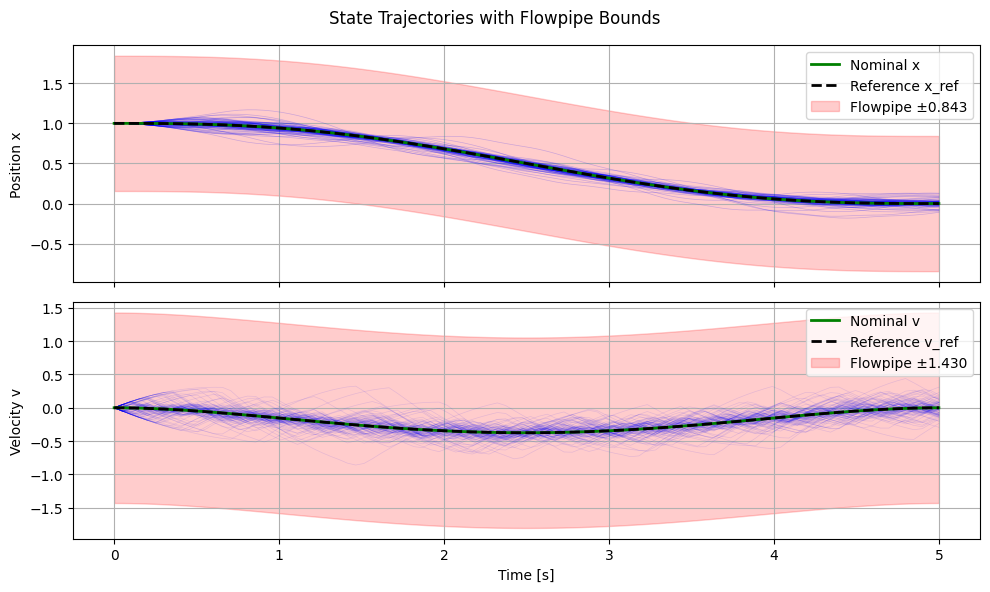

In [ ]:
import matplotlib.pyplot as plt

if sol is not None:
    bounds_upper = sol["bounds_upper"]
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Plot x with flowpipe
    ax = axes[0]
    for traj in state_trajectories:
        ax.plot(t_eval, traj[0], 'b-', alpha=0.1, linewidth=0.5)
    ax.plot(t_eval, nom_x, 'g-', linewidth=2, label='Nominal x')
    ax.plot(t_eval, x_ref_traj, 'k--', linewidth=2, label='Reference x_ref')
    # Flowpipe bounds around reference
    ax.fill_between(t_eval, x_ref_traj - bounds_upper[0], x_ref_traj + bounds_upper[0], 
                    color='r', alpha=0.2, label=f'Flowpipe ±{bounds_upper[0]:.3f}')
    ax.set_ylabel('Position x')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    # Plot v with flowpipe
    ax = axes[1]
    for traj in state_trajectories:
        ax.plot(t_eval, traj[1], 'b-', alpha=0.1, linewidth=0.5)
    ax.plot(t_eval, nom_v, 'g-', linewidth=2, label='Nominal v')
    ax.plot(t_eval, v_ref_traj, 'k--', linewidth=2, label='Reference v_ref')
    # Flowpipe bounds around reference
    ax.fill_between(t_eval, v_ref_traj - bounds_upper[1], v_ref_traj + bounds_upper[1], 
                    color='r', alpha=0.2, label=f'Flowpipe ±{bounds_upper[1]:.3f}')
    ax.set_ylabel('Velocity v')
    ax.set_xlabel('Time [s]')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    fig.suptitle('State Trajectories with Flowpipe Bounds')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/state_flowpipe.png", dpi=150)
    plt.show()

## Plot Error Trajectories

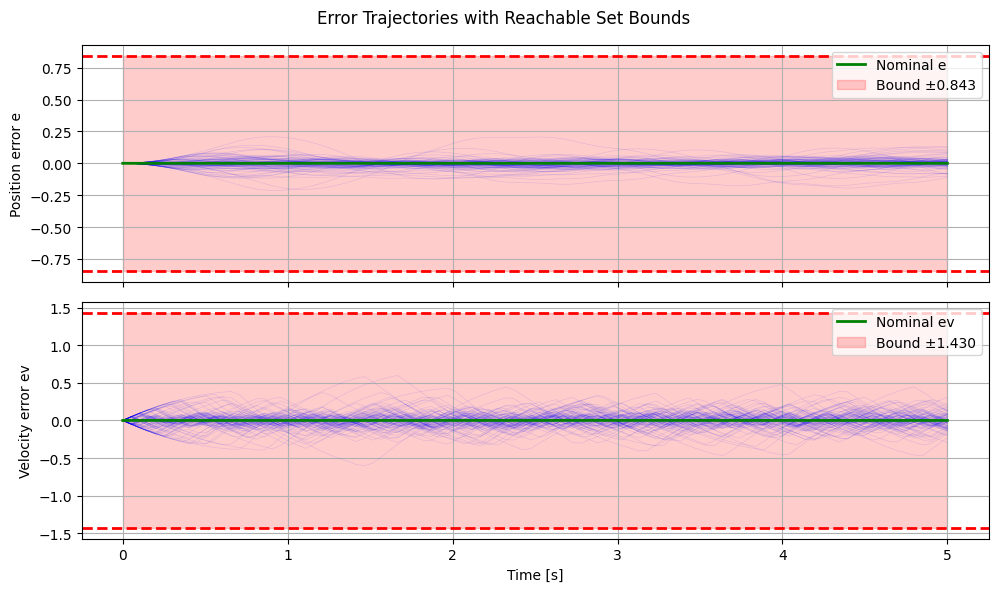


Maximum observed errors vs bounds:
  e:  max = 0.2131, bound = 0.8431
  ev: max = 0.6023, bound = 1.4296


In [36]:
if sol is not None:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Plot position error
    ax = axes[0]
    for traj in error_trajectories:
        ax.plot(t_eval, traj[0], 'b-', alpha=0.1, linewidth=0.5)
    ax.plot(t_eval, nom_e, 'g-', linewidth=2, label='Nominal e')
    ax.axhline(bounds_upper[0], color='r', linestyle='--', linewidth=2)
    ax.axhline(-bounds_upper[0], color='r', linestyle='--', linewidth=2)
    ax.fill_between(t_eval, -bounds_upper[0], bounds_upper[0], color='r', alpha=0.2, 
                    label=f'Bound ±{bounds_upper[0]:.3f}')
    ax.set_ylabel('Position error e')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    # Plot velocity error
    ax = axes[1]
    for traj in error_trajectories:
        ax.plot(t_eval, traj[1], 'b-', alpha=0.1, linewidth=0.5)
    ax.plot(t_eval, nom_ev, 'g-', linewidth=2, label='Nominal ev')
    ax.axhline(bounds_upper[1], color='r', linestyle='--', linewidth=2)
    ax.axhline(-bounds_upper[1], color='r', linestyle='--', linewidth=2)
    ax.fill_between(t_eval, -bounds_upper[1], bounds_upper[1], color='r', alpha=0.2,
                    label=f'Bound ±{bounds_upper[1]:.3f}')
    ax.set_ylabel('Velocity error ev')
    ax.set_xlabel('Time [s]')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    fig.suptitle('Error Trajectories with Reachable Set Bounds')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/error_trajectories.png", dpi=150)
    plt.show()
    
    # Print max errors vs bounds
    max_e = max(np.max(np.abs(traj[0])) for traj in error_trajectories)
    max_ev = max(np.max(np.abs(traj[1])) for traj in error_trajectories)
    print(f"\nMaximum observed errors vs bounds:")
    print(f"  e:  max = {max_e:.4f}, bound = {bounds_upper[0]:.4f}")
    print(f"  ev: max = {max_ev:.4f}, bound = {bounds_upper[1]:.4f}")

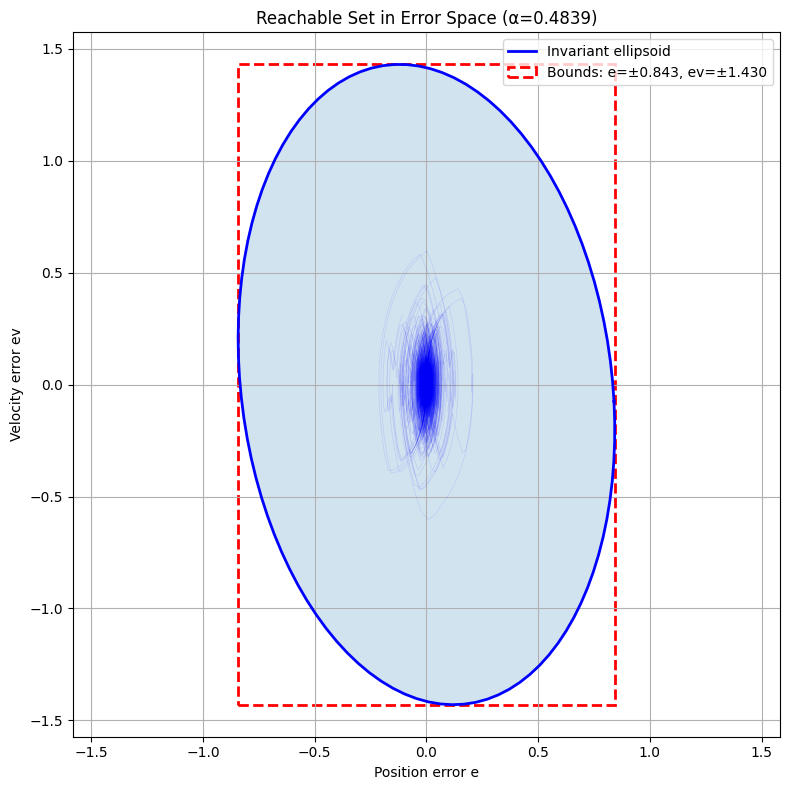

In [37]:
# 2D ellipsoid plot in error space
if sol is not None and sol.get('P') is not None:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Monte Carlo error trajectories
    for traj in error_trajectories:
        ax.plot(traj[0], traj[1], 'b-', alpha=0.1, linewidth=0.5)
    
    # Plot invariant ellipsoid
    theta = np.linspace(0, 2*np.pi, 100)
    circle = np.array([np.cos(theta), np.sin(theta)])
    
    P = sol['P']
    mu = sol['mu'][0]
    eigvals_P, eigvecs = np.linalg.eigh(P)
    P_sqrt_inv = eigvecs @ np.diag(1/np.sqrt(eigvals_P)) @ eigvecs.T
    scale = np.sqrt(mu * dist_bound**2)
    ellipse = scale * P_sqrt_inv @ circle
    
    ax.plot(ellipse[0], ellipse[1], 'b-', linewidth=2, label='Invariant ellipsoid')
    ax.fill(ellipse[0], ellipse[1], alpha=0.2)
    
    # Plot bounding box
    r_e, r_ev = bounds_upper
    rect = plt.Rectangle((-r_e, -r_ev), 2*r_e, 2*r_ev, fill=False, 
                        edgecolor='r', linestyle='--', linewidth=2,
                        label=f'Bounds: e=±{r_e:.3f}, ev=±{r_ev:.3f}')
    ax.add_patch(rect)
    
    ax.set_xlabel('Position error e')
    ax.set_ylabel('Velocity error ev')
    ax.set_title(f'Reachable Set in Error Space (α={sol["alpha"]:.4f})')
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/error_ellipsoid.png", dpi=150)
    plt.show()

In [38]:
print("=== Summary ===")
print(f"Model: {ir.model_name}")
print(f"States: {ss.get_state_names()}")
print(f"Inputs: {ss.get_input_names()}")
print(f"Disturbance inputs: {disturbance_inputs}")
print(f"\nModel dynamics: {model_type}")
print(f"Error dynamics: {'LINEAR' if error_is_linear else 'NONLINEAR'}")

if sol:
    print(f"\nLMI Results:")
    print(f"  Status: {sol['status']}")
    print(f"  Alpha: {sol['alpha']:.6f}")
    print(f"  bounds_upper: {sol['bounds_upper']}")
    print(f"\nExpected (from basic example):")
    print(f"  bounds_upper: [0.84309921, 1.42957659]")

=== Summary ===
Model: ClosedLoop
States: ['x', 'v']
Inputs: ['x_ref', 'v_ref', 'u_ff', 'd']
Disturbance inputs: ['d']

Model dynamics: DynamicsClass.LINEAR
Error dynamics: LINEAR

LMI Results:
  Status: optimal
  Alpha: 0.483873
  bounds_upper: [0.84309921 1.4295766 ]

Expected (from basic example):
  bounds_upper: [0.84309921, 1.42957659]
